In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, classification_report
from sklearn.neural_network import MLPClassifier
seed = 3000
np.random.seed(seed)

In [71]:
filename = '/home/vala/Documents/FYS4155 Machine Learning/yelp_v2.csv'
df = pd.read_csv(filename)

#don't know how to handle postalcodes
df.drop(columns=['postal_code'], inplace=True)
for col in df.columns:
    un = df[col].unique()
    # Standardize all non-categorical variables
    if len(un) <= 3 or col in ['RestaurantsPriceRange2', 'stars', 'rating']:
        continue
    print(col, len(un))
    df[col] = StandardScaler().fit_transform(df[col].to_numpy().reshape(-1, 1))



#17 indicator variables 
#58 predictors 

df['rating'] = np.where(df['rating'] == 1, 0, df['rating'])
df['rating'] = np.where(df['rating'] == 2, 0, df['rating'])
df['rating'] = np.where(df['rating'] == 3, 0, df['rating'])
df['rating'] = np.where(df['rating'] == 4, 0, df['rating'])
df['rating'] = np.where(df['rating'] == 5, 1, df['rating'])

X = df.loc[: ,df.columns != 'rating'].values
y = df.loc[:, df.columns == 'rating'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size= 0.5, stratify = y_test, random_state=seed)


yes = df.rating.sum()
no = len(df)-yes

yes_perc = round(yes/len(df)*100, 1)
no_perc = round(no/len(df)*100, 1)

print("Top Rating: ", yes_perc)
print("Under five rating: ", no_perc)
#Fra 38 til 57


review_count 498
longitude 17793
latitude 17970
compliment_plain 1195
useful 3894
compliment_writer 705
funny 2783
compliment_profile 292
compliment_cute 264
compliment_funny 1238
compliment_note 759
fans 527
compliment_photos 668
compliment_cool 1238
compliment_hot 1051
cool 3155
review_count.1 498
average_stars 396
compliment_more 302
friends 2081
compliment_list 174
time 475694
Top Rating:  44.1
Under five rating:  55.9


## ScikitLearn Logistic Classification

/home/vala/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Area under curve LogReg_skl_test:  0.8176498928022927
Area under curve LogReg_skl_train:  0.8185053400702951
Classification report test:
              precision    recall  f1-score   support

         0.0       0.75      0.81      0.78     27920
         1.0       0.73      0.66      0.69     22017

    accuracy                           0.74     49937
   macro avg       0.74      0.73      0.73     49937
weighted avg       0.74      0.74      0.74     49937

Classification report train:
              precision    recall  f1-score   support

         0.0       0.75      0.81      0.78    223361
         1.0       0.73      0.66      0.69    176138

    accuracy                           0.74    399499
   macro avg       0.74      0.73      0.74    399499
weighted avg       0.74      0.74      0.74    399499



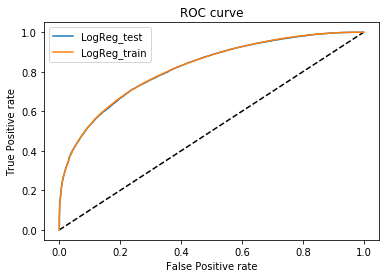

In [36]:
eta = 0.002 
clf = SGDClassifier(loss = 'log', penalty='l1', alpha = 0.01, max_iter=20, eta0=eta, learning_rate='constant', fit_intercept=True, random_state=seed)
clf.fit(X_train, y_train)
final_betas_LGSKL = clf.coef_.T
#print(clf.intercept_)
#print(clf.coef_)
prob_LGSKL_test = clf.predict_proba(X_test)[:,1]
prob_LGSKL_train = clf.predict_proba(X_train)[:,1]

y_LGSKLpred_test = clf.predict(X_test)
y_LGSKLpred_train = clf.predict(X_train)

#print(clf.score(X_test, y_test))

false_pos_LogReg_Skl_test, true_pos_LogReg_Skl_test = roc_curve(y_test, prob_LGSKL_test)[0:2]
false_pos_LogReg_Skl_train, true_pos_LogReg_Skl_train = roc_curve(y_train, prob_LGSKL_train)[0:2]

print("Area under curve LogReg_skl_test: ", auc(false_pos_LogReg_Skl_test, true_pos_LogReg_Skl_test))
print("Area under curve LogReg_skl_train: ", auc(false_pos_LogReg_Skl_train, true_pos_LogReg_Skl_train))

print("Classification report test:")
print(classification_report(y_test, y_LGSKLpred_test))
print("Classification report train:")
print(classification_report(y_train, y_LGSKLpred_train))

plt.plot([0, 1], [0, 1], "k--")
plt.plot(false_pos_LogReg_Skl_test, true_pos_LogReg_Skl_test, label="LogReg_test")
plt.plot(false_pos_LogReg_Skl_train, true_pos_LogReg_Skl_train, label="LogReg_train")
plt.legend()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC curve")
plt.show()

[0.7472284  0.7472284  0.74719586 0.74711827 0.7461045  0.74392677
 0.73871023 0.55910278 0.55910278 0.55910278]
[0.74495865 0.74489857 0.74477842 0.74443799 0.74469832 0.7433366
 0.73698861 0.55910447 0.55910447 0.55910447]


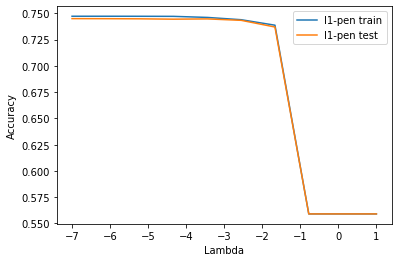

In [74]:
# Hypertuning for classification

alpha_array = np.logspace(-7,1, 10)

eta = 0.002 
accuracy_train = np.zeros((len(alpha_array)))
#print(accuracy_train)
accuracy_test = np.zeros((len(alpha_array)))
for i, alpha in enumerate(alpha_array):
    clf = SGDClassifier(loss = 'log', penalty='l1', alpha=alpha, max_iter=20, eta0=eta, learning_rate='constant', fit_intercept=True, random_state=seed)
    clf.fit(X_train, y_train.flatten())
    y_HYPERpred_train = clf.predict(X_train)
    y_HYPERpred_test = clf.predict(X_test)
    accuracy_train[i] = accuracy_score(y_train, y_HYPERpred_train)
    accuracy_test[i] = accuracy_score(y_test, y_HYPERpred_test)
    
print(accuracy_train)  
print(accuracy_test)
plt.plot(np.log10(alpha_array), accuracy_train, label='l1-pen train')
plt.plot(np.log10(alpha_array), accuracy_test, label='l1-pen test' )
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## Neural Network Classification

In [ ]:
#Hypertuning 



/home/vala/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Area under curve LogReg_skl_test:  0.8214658300638489
Area under curve LogReg_skl_train:  0.8226753365768326
Classification report test:
              precision    recall  f1-score   support

         0.0       0.74      0.87      0.80     27920
         1.0       0.78      0.61      0.69     22017

    accuracy                           0.75     49937
   macro avg       0.76      0.74      0.74     49937
weighted avg       0.76      0.75      0.75     49937

Classification report train:
              precision    recall  f1-score   support

         0.0       0.74      0.86      0.80    223361
         1.0       0.78      0.62      0.69    176138

    accuracy                           0.75    399499
   macro avg       0.76      0.74      0.74    399499
weighted avg       0.76      0.75      0.75    399499



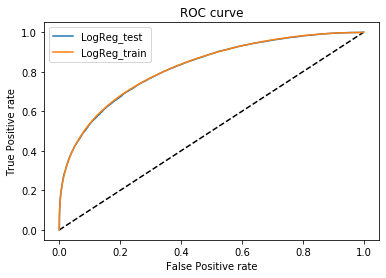

In [58]:
epochs = 20
batch_size = 25
eta = 0.1
lmbd = 0.01
n_hidden_neurons = 41
n_categories = 1


dnn = MLPClassifier(hidden_layer_sizes=(n_hidden_neurons,),activation='logistic', solver='sgd', alpha=0.01, batch_size=batch_size,
    learning_rate_init=eta, 
    max_iter=epochs,random_state=seed, momentum=0, shuffle=False)

dnn.fit(X_train, y_train.ravel())

y_MLPCpred_test = dnn.predict(X_test)
y_MLPCpred_train = dnn.predict(X_train)

prob_MLPC_test = clf.predict_proba(X_test)[:,1]
prob_MLPC_train = clf.predict_proba(X_train)[:,1]


#print(clf.score(X_test, y_test))

false_pos_MLPC_Skl_test, true_pos_MLPC_Skl_test = roc_curve(y_test, prob_MLPC_test)[0:2]
false_pos_MLPC_Skl_train, true_pos_MLPC_Skl_train = roc_curve(y_train, prob_MLPC_train)[0:2]

print("Area under curve LogReg_skl_test: ", auc(false_pos_MLPC_Skl_test, true_pos_MLPC_Skl_test))
print("Area under curve LogReg_skl_train: ", auc(false_pos_MLPC_Skl_train, true_pos_MLPC_Skl_train))

print("Classification report test:")
print(classification_report(y_test, y_MLPCpred_test))
print("Classification report train:")
print(classification_report(y_train, y_MLPCpred_train))

plt.plot([0, 1], [0, 1], "k--")
plt.plot(false_pos_MLPC_Skl_test, true_pos_MLPC_Skl_test, label="LogReg_test")
plt.plot(false_pos_MLPC_Skl_train, true_pos_MLPC_Skl_train, label="LogReg_train")
plt.legend()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC curve")
plt.show()